# Install libraries

In [1]:
# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 885.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Import Library

In [40]:
# Numpy for matrices
import numpy as np
import torch
from collections import Counter

# Torch and pytorch geometric
import torch.nn.functional as F
from torch.nn import Linear, Dropout, LayerNorm, ReLU
from torch_geometric.nn import GCNConv, GATv2Conv, GCN2Conv, DeepGCNLayer, GENConv

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dataset and Torch geometric methods: DropNodes, DropEdges, JKNets
from torch_geometric.datasets import Planetoid, KarateClub
from torch_geometric.utils import remove_isolated_nodes, degree, to_networkx, dropout_adj, dropout_node, dropout_edge
from torch_geometric.nn import JumpingKnowledge

In [6]:
np.random.seed(0)

In [21]:
# Check Pytroch version
torchversion = torch.__version__
torchversion

'2.4.1+cu121'

# Dataset

In [8]:
# Import Cora dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="cora")

data = dataset[0]

Processing...
Done!


In [9]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [10]:
# Check the isolated node

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


# Visualize the dataset

## Plot the data

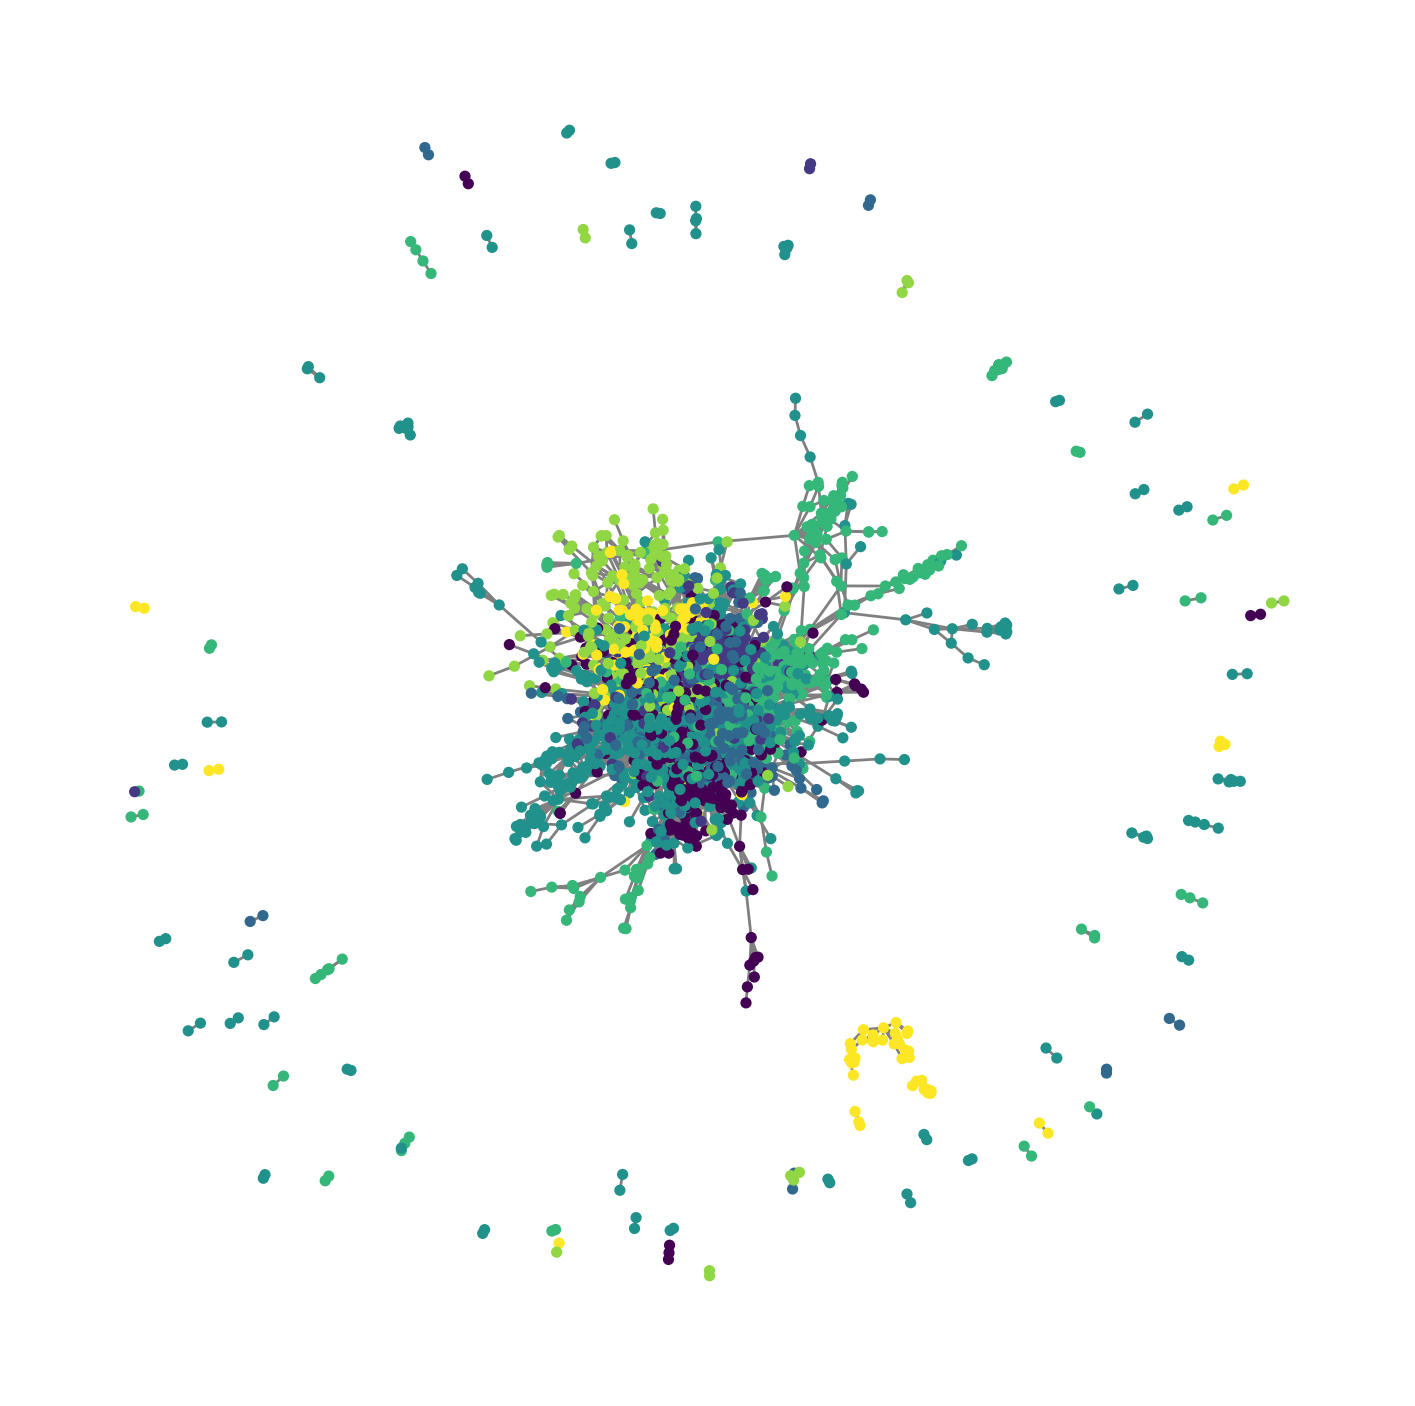

In [11]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

## Plot the nodes' degree

<BarContainer object of 37 artists>

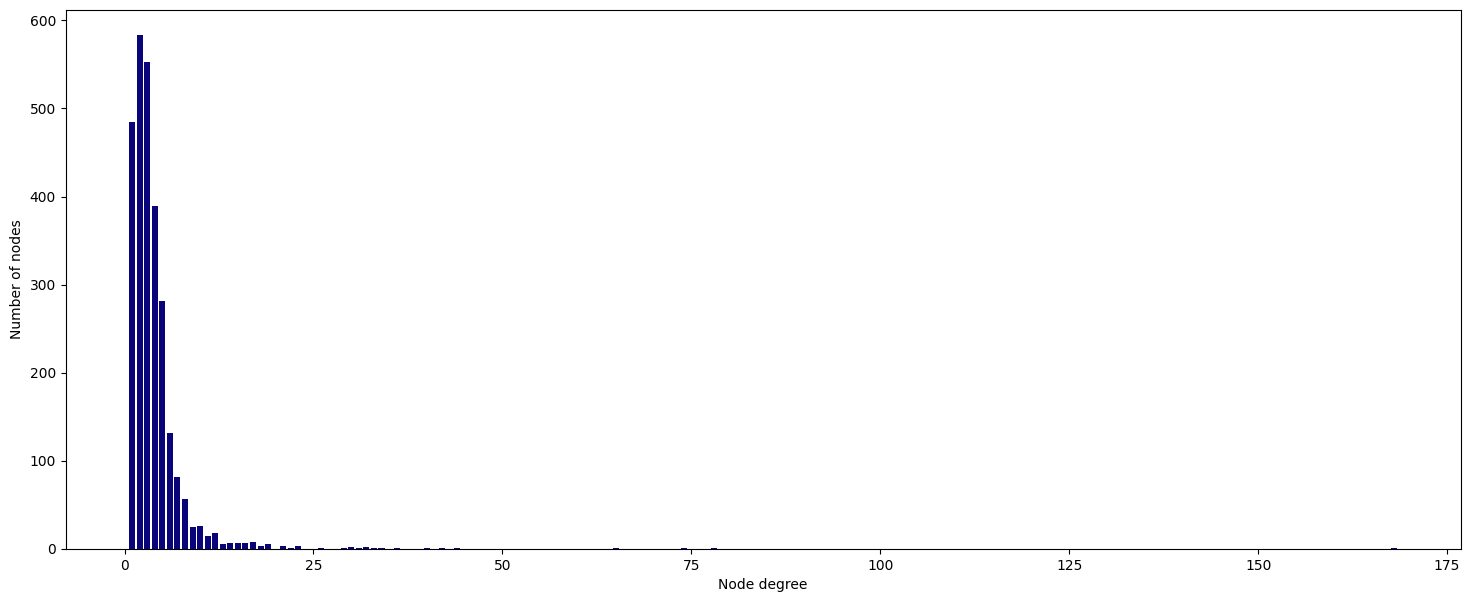

In [12]:
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# 1. GCN model with Dropout method

In [13]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

## 1.1 Train and Test function with Accuracy metric tracking

In [16]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 15

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

## 1.2. Training GCN with Dropout

In [17]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.959 | Train Acc:  15.00% | Val Loss: 1.95 | Val Acc: 12.40%
Epoch   1 | Train Loss: 1.867 | Train Acc:  37.14% | Val Loss: 1.91 | Val Acc: 22.40%
Epoch   2 | Train Loss: 1.775 | Train Acc:  54.29% | Val Loss: 1.87 | Val Acc: 31.40%
Epoch   3 | Train Loss: 1.670 | Train Acc:  66.43% | Val Loss: 1.82 | Val Acc: 37.00%
Epoch   4 | Train Loss: 1.548 | Train Acc:  77.14% | Val Loss: 1.71 | Val Acc: 52.60%
Epoch   5 | Train Loss: 1.432 | Train Acc:  75.71% | Val Loss: 1.65 | Val Acc: 53.00%
Epoch   6 | Train Loss: 1.298 | Train Acc:  80.00% | Val Loss: 1.54 | Val Acc: 57.20%
Epoch   7 | Train Loss: 1.159 | Train Acc:  81.43% | Val Loss: 1.49 | Val Acc: 57.00%
Epoch   8 | Train Loss: 1.109 | Train Acc:  85.71% | Val Loss: 1.44 | Val Acc: 55.40%
Epoch   9 | Train Loss: 1.022 | Train Acc:  82.86% | Val Loss: 1.40 | Val Acc: 59.00%
Epoch  10 | Train Loss: 0.941 | Train Acc:  86.43% | Val Loss: 1.33 | Val Acc: 6

# 2. GCN model with DropEdges
## 2.1. GCN with DropEdges Construction

In [18]:
class GCN_dropEdges(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

## 2.2. Training the model

In [45]:
def train_dropEdges(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 15

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        edge_index1, _ = dropout_edge(data.edge_index, p=0.5)
        _, out = model(data.x, edge_index1 )
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [46]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train_dropEdges(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.963 | Train Acc:  14.29% | Val Loss: 1.98 | Val Acc: 6.40%
Epoch   1 | Train Loss: 1.894 | Train Acc:  28.57% | Val Loss: 1.94 | Val Acc: 19.00%
Epoch   2 | Train Loss: 1.813 | Train Acc:  33.57% | Val Loss: 1.91 | Val Acc: 25.00%
Epoch   3 | Train Loss: 1.749 | Train Acc:  45.00% | Val Loss: 1.89 | Val Acc: 25.60%
Epoch   4 | Train Loss: 1.671 | Train Acc:  55.71% | Val Loss: 1.81 | Val Acc: 32.00%
Epoch   5 | Train Loss: 1.549 | Train Acc:  59.29% | Val Loss: 1.77 | Val Acc: 36.60%
Epoch   6 | Train Loss: 1.407 | Train Acc:  66.43% | Val Loss: 1.73 | Val Acc: 42.20%
Epoch   7 | Train Loss: 1.288 | Train Acc:  67.14% | Val Loss: 1.68 | Val Acc: 42.80%
Epoch   8 | Train Loss: 1.255 | Train Acc:  72.86% | Val Loss: 1.63 | Val Acc: 46.80%
Epoch   9 | Train Loss: 1.192 | Train Acc:  72.14% | Val Loss: 1.58 | Val Acc: 50.00%
Epoch  10 | Train Loss: 1.084 | Train Acc:  77.14% | Val Loss: 1.58 | Val Acc: 47

# 3. GCN model with DropNodes

In [22]:
def train_dropNodes(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 15

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        edge_index1, _, _ = dropout_node(data.edge_index)
        _, out = model(data.x, edge_index1 )
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [23]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train_dropNodes(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.980 | Train Acc:  12.14% | Val Loss: 1.97 | Val Acc: 13.40%
Epoch   1 | Train Loss: 1.897 | Train Acc:  25.00% | Val Loss: 1.93 | Val Acc: 15.00%
Epoch   2 | Train Loss: 1.829 | Train Acc:  30.71% | Val Loss: 1.89 | Val Acc: 25.40%
Epoch   3 | Train Loss: 1.720 | Train Acc:  48.57% | Val Loss: 1.86 | Val Acc: 30.20%
Epoch   4 | Train Loss: 1.653 | Train Acc:  52.14% | Val Loss: 1.83 | Val Acc: 35.40%
Epoch   5 | Train Loss: 1.605 | Train Acc:  56.43% | Val Loss: 1.78 | Val Acc: 34.60%
Epoch   6 | Train Loss: 1.490 | Train Acc:  60.71% | Val Loss: 1.77 | Val Acc: 37.00%
Epoch   7 | Train Loss: 1.386 | Train Acc:  64.29% | Val Loss: 1.75 | Val Acc: 36.80%
Epoch   8 | Train Loss: 1.371 | Train Acc:  66.43% | Val Loss: 1.72 | Val Acc: 38.40%
Epoch   9 | Train Loss: 1.288 | Train Acc:  65.00% | Val Loss: 1.70 | Val Acc: 39.20%
Epoch  10 | Train Loss: 1.171 | Train Acc:  67.86% | Val Loss: 1.67 | Val Acc: 4

# 4. Jumping Knowledge Network Model (JKNet)

In [24]:
class JKNet(torch.nn.Module):
    def __init__(self, dataset, mode='max', num_layers=6, hidden=16):
        super(JKNet, self).__init__()
        self.num_layers = num_layers
        self.mode = mode

        self.conv0 = GCNConv(dataset.num_node_features, hidden)
        self.dropout0 = torch.nn.Dropout(p=0.5)

        for i in range(1, self.num_layers):
            setattr(self, 'conv{}'.format(i), GCNConv(hidden, hidden))
            setattr(self, 'dropout{}'.format(i), torch.nn.Dropout(p=0.5))

        self.jk = JumpingKnowledge(mode=mode)
        if mode == 'max':
            self.fc = torch.nn.Linear(hidden, dataset.num_classes)
        elif mode == 'cat':
            self.fc = torch.nn.Linear(num_layers * hidden, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    def forward(self, x, edge_index):

        layer_out = []
        for i in range(self.num_layers):
            conv = getattr(self, 'conv{}'.format(i))
            dropout = getattr(self, 'dropout{}'.format(i))
            x = dropout(F.relu(conv(x, edge_index)))
            layer_out.append(x)

        h = self.jk(layer_out)
        h = self.fc(h)
        return h, F.log_softmax(h, dim=1)

In [25]:
%%time
jkGCN = JKNet(dataset)
print(jkGCN)

JKNet(
  (conv0): GCNConv(1433, 16)
  (dropout0): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(16, 16)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 16)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(16, 16)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): GCNConv(16, 16)
  (dropout4): Dropout(p=0.5, inplace=False)
  (conv5): GCNConv(16, 16)
  (dropout5): Dropout(p=0.5, inplace=False)
  (jk): JumpingKnowledge(max)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
CPU times: user 10.5 ms, sys: 1.94 ms, total: 12.4 ms
Wall time: 12.2 ms


## Train the model

In [26]:
# Train
train(jkGCN, data)
# Test
acc = test(jkGCN, data)
print(f'\n test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.959 | Train Acc:  14.29% | Val Loss: 2.00 | Val Acc: 12.40%
Epoch   1 | Train Loss: 1.930 | Train Acc:  17.86% | Val Loss: 1.98 | Val Acc: 11.20%
Epoch   2 | Train Loss: 1.909 | Train Acc:  17.14% | Val Loss: 1.97 | Val Acc: 13.40%
Epoch   3 | Train Loss: 1.849 | Train Acc:  29.29% | Val Loss: 1.93 | Val Acc: 16.40%
Epoch   4 | Train Loss: 1.818 | Train Acc:  32.14% | Val Loss: 1.90 | Val Acc: 19.00%
Epoch   5 | Train Loss: 1.792 | Train Acc:  28.57% | Val Loss: 1.86 | Val Acc: 22.60%
Epoch   6 | Train Loss: 1.685 | Train Acc:  48.57% | Val Loss: 1.81 | Val Acc: 26.80%
Epoch   7 | Train Loss: 1.672 | Train Acc:  38.57% | Val Loss: 1.76 | Val Acc: 27.80%
Epoch   8 | Train Loss: 1.538 | Train Acc:  49.29% | Val Loss: 1.71 | Val Acc: 28.60%
Epoch   9 | Train Loss: 1.499 | Train Acc:  54.29% | Val Loss: 1.66 | Val Acc: 33.80%
Epoch  10 | Train Loss: 1.484 | Train Acc:  45.71% | Val Loss: 1.61 | Val Acc: 33.80%
Epoch  11 | Train Loss: 1.424 | Train Acc:  49.29% | V

# 5. DeepGCN model

In [27]:
class DeepGCN(torch.nn.Module):
	def __init__(self,num_features, num_classes, dim =16, num_layers =2, drop=0.5):
		super().__init__()

		self.node_encoder = Linear(num_features, dim)
		#self.edge_encoder = Linear(data.edge_attr.size(-1), hidden_channels)
		self.h = None
		self.layers = torch.nn.ModuleList()
		for i in range(1, num_layers + 1):
			conv = GENConv(dim, dim, aggr='softmax', t=1.0, learn_t=True, num_layers=2, norm='layer')
			norm = LayerNorm(dim, elementwise_affine=True)
			act = ReLU(inplace=True)

			layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,ckpt_grad=i % 3)
			self.layers.append(layer)
		self.mlp = Linear(dim, num_classes)
		self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)


	def forward(self, x, edge_index):
		x = self.node_encoder(x)
		x = self.layers[0].conv(x, edge_index)

		for layer in self.layers[1:]:
			x = layer(x, edge_index)

		x = self.layers[0].act(self.layers[0].norm(x))
		x = F.dropout(x, p=0.1, training=self.training)
		x = self.mlp(x)
		self.h = x
		return x, F.log_softmax(x, dim=1)

In [33]:
%%time
#(self,num_features, num_classes, dim =16, num_layers =2, drop=0.5):
# Create DeepGCN model
deepGCN = DeepGCN(dataset.num_features, dataset.num_classes)
print(deepGCN)

DeepGCN(
  (node_encoder): Linear(in_features=1433, out_features=16, bias=True)
  (layers): ModuleList(
    (0-1): 2 x DeepGCNLayer(block=res+)
  )
  (mlp): Linear(in_features=16, out_features=7, bias=True)
)
CPU times: user 8.16 ms, sys: 961 µs, total: 9.12 ms
Wall time: 10.3 ms


In [34]:
# Train
train(deepGCN, data)

# Test
acc = test(deepGCN, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch   0 | Train Loss: 1.960 | Train Acc:  17.14% | Val Loss: 1.96 | Val Acc: 18.20%
Epoch   1 | Train Loss: 1.873 | Train Acc:  20.00% | Val Loss: 1.93 | Val Acc: 17.20%
Epoch   2 | Train Loss: 1.756 | Train Acc:  38.57% | Val Loss: 1.80 | Val Acc: 37.00%
Epoch   3 | Train Loss: 1.627 | Train Acc:  49.29% | Val Loss: 1.72 | Val Acc: 38.00%
Epoch   4 | Train Loss: 1.521 | Train Acc:  52.86% | Val Loss: 1.66 | Val Acc: 40.80%
Epoch   5 | Train Loss: 1.424 | Train Acc:  65.00% | Val Loss: 1.59 | Val Acc: 49.40%
Epoch   6 | Train Loss: 1.362 | Train Acc:  71.43% | Val Loss: 1.56 | Val Acc: 50.40%
Epoch   7 | Train Loss: 1.249 | Train Acc:  82.14% | Val Loss: 1.53 | Val Acc: 52.80%
Epoch   8 | Train Loss: 1.176 | Train Acc:  81.43% | Val Loss: 1.49 | Val Acc: 53.60%
Epoch   9 | Train Loss: 1.070 | Train Acc:  89.29% | Val Loss: 1.44 | Val Acc: 56.20%
Epoch  10 | Train Loss: 0.986 | Train Acc:  90.00% | Val Loss: 1.40 | Val Acc: 58.20%
Epoch  11 | Train Loss: 0.939 | Train Acc:  90.71% | V

# 6. GCNII Model

In [35]:
class GCNII(torch.nn.Module):
	def __init__(self, num_features, num_classes, hidden_channels = 16, num_layers =2, shared_weights=True, dropout=0.0):
		super().__init__()
		self.lins = torch.nn.ModuleList()
		self.proj = Linear(1, 64)
		self.lins1 = Linear(num_features, hidden_channels)
		self.lins2  = Linear(hidden_channels, num_classes)

		self.convs = torch.nn.ModuleList()
		for layer in range(num_layers):
			self.convs.append(
				GCN2Conv(hidden_channels, 0.1, 0.5, layer + 1, shared_weights, normalize=False))
		self.h = None
		self.dropout = dropout
		self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)
	def forward(self, x, edge_index):

		x = F.dropout(x, self.dropout, training=self.training)
		x =  self.lins1(x)
		x = x_0 = x.relu()

		for conv in self.convs:
			x = F.dropout(x, self.dropout, training=self.training)
			x = conv(x, x_0, edge_index)
			x = x.relu()
		x = F.dropout(x, self.dropout, training=self.training)
		x = self.lins2(x)
		self.h =x
		return x, x.log_softmax(dim=-1)

In [36]:
%%time

gcnii = GCNII(dataset.num_features, dataset.num_classes)
print(gcnii)

GCNII(
  (lins): ModuleList()
  (proj): Linear(in_features=1, out_features=64, bias=True)
  (lins1): Linear(in_features=1433, out_features=16, bias=True)
  (lins2): Linear(in_features=16, out_features=7, bias=True)
  (convs): ModuleList(
    (0): GCN2Conv(16, alpha=0.1, beta=0.4054651081081644)
    (1): GCN2Conv(16, alpha=0.1, beta=0.22314355131420976)
  )
)
CPU times: user 54.5 ms, sys: 1.94 ms, total: 56.4 ms
Wall time: 57 ms


In [47]:
# Train
train(gcnii, data)

# Test
acc = test(gcnii, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 0.146 | Train Acc:  99.29% | Val Loss: 1.69 | Val Acc: 72.00%
Epoch   1 | Train Loss: 0.126 | Train Acc: 100.00% | Val Loss: 1.75 | Val Acc: 72.60%
Epoch   2 | Train Loss: 0.111 | Train Acc: 100.00% | Val Loss: 1.83 | Val Acc: 73.20%
Epoch   3 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 1.91 | Val Acc: 73.80%
Epoch   4 | Train Loss: 0.089 | Train Acc: 100.00% | Val Loss: 1.98 | Val Acc: 74.20%
Epoch   5 | Train Loss: 0.078 | Train Acc: 100.00% | Val Loss: 2.03 | Val Acc: 74.20%
Epoch   6 | Train Loss: 0.070 | Train Acc: 100.00% | Val Loss: 2.08 | Val Acc: 73.40%
Epoch   7 | Train Loss: 0.063 | Train Acc: 100.00% | Val Loss: 2.14 | Val Acc: 73.20%
Epoch   8 | Train Loss: 0.057 | Train Acc: 100.00% | Val Loss: 2.20 | Val Acc: 73.20%
Epoch   9 | Train Loss: 0.051 | Train Acc: 100.00% | Val Loss: 2.27 | Val Acc: 73.60%
Epoch  10 | Train Loss: 0.046 | Train Acc: 100.00% | Val Loss: 2.34 | Val Acc: 73.40%
Epoch  11 | Train Loss: 0.042 | Train Acc: 100.00% | V

## 6.1. Visualize DeepGCN with t-SNE

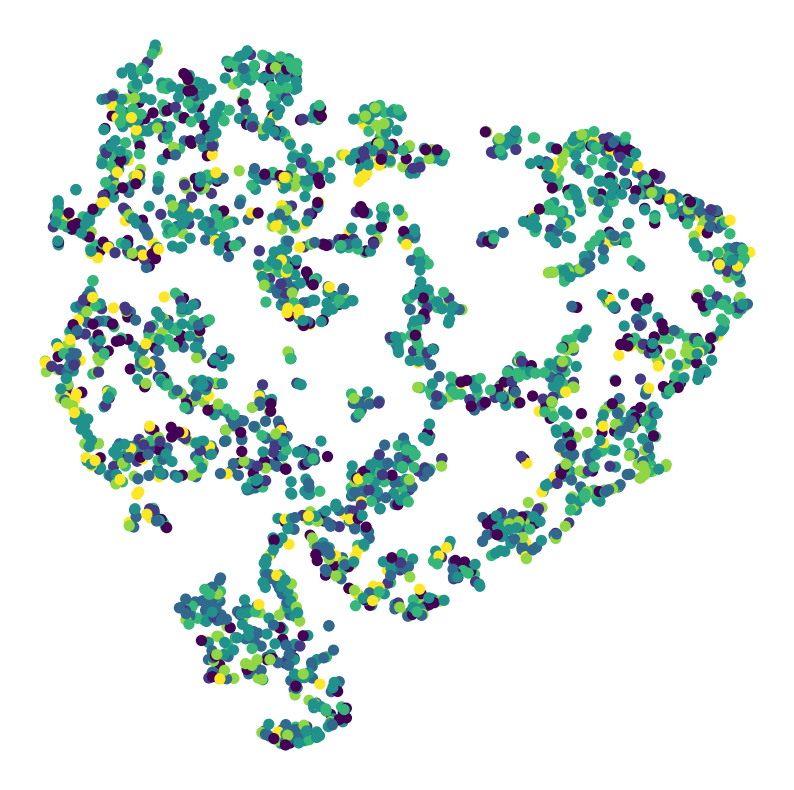

In [38]:
# Initialize new untrained model
untrained_DeeperGCN = DeepGCN(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_DeeperGCN(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

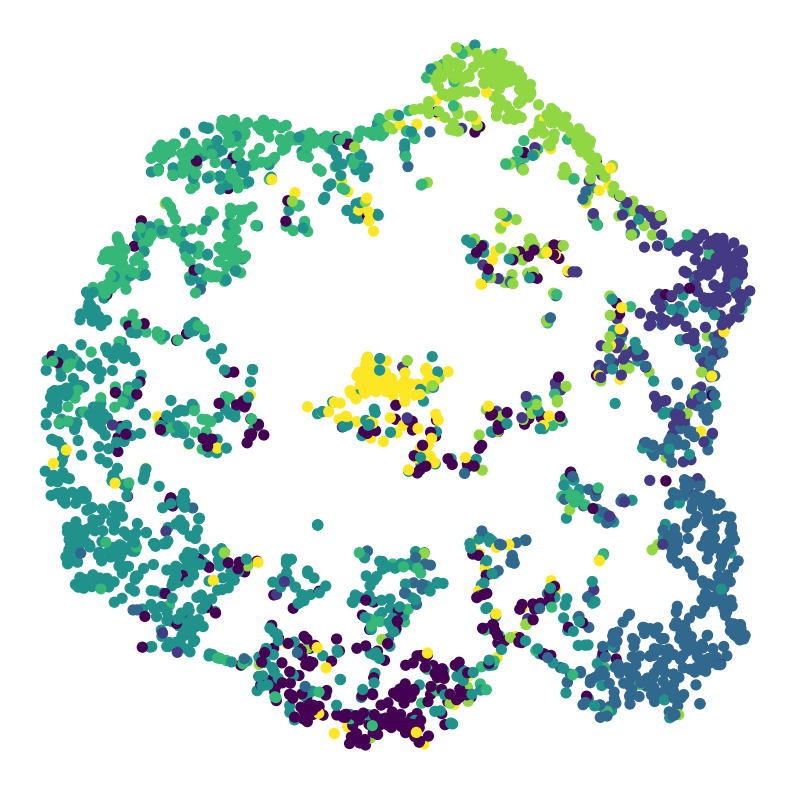

In [39]:
# Get embeddings
h, _ = deepGCN(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()